# NOTEBOOK 04a: RANDOM FOREST

This notebook will fit and optimize a Random Forest model on the Tfidf vectorized data. The Random Forest algorithm is a CART method that randomly selects features at each node and evaluates the gain in information through either reduction in entropy or gini. It then uses those recursive fittings to determine the relative importance of each feature for sorting classes. Features that produce splits resulting in pure classes are weighted the highest and therefore provide the most predicive value.

In [1]:
import time
import pandas as pd
import numpy as np

from scipy import sparse
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

np.random.seed(42)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

In [2]:
!ls '../assets'

1544820504_comments_df.csv     1545277666_y_test.csv
1544843302_comments_df.csv     1545277666_y_train.csv
1544988010_comments_df.csv     1545285057_tfidf_col.csv
1545241316_clean_target.csv    1545336727_SVD_col.csv
1545241316_clean_text.csv      1545336727_XtestSVD_coo.npz
1545249401_cvec_coo.npz        1545336727_XtestSVD_raw.csv
1545249401_cvec_coo_col.csv    1545336727_XtrainSVD_coo.npz
1545254581_clean_text.csv      1545336727_XtrainSVD_raw.csv
1545266972_clean_text.csv      cvec_1545266972_coo_col.csv
1545266972_cvec_coo.npz        file_log.txt
1545266972_tfidf_coo.npz       test_1545277666_tfidf_coo.npz
1545272821_eda_words.csv       tfidf_1545266972_coo_col.csv
1545277666_tfidf_col.csv       train_1545277666_tfidf_coo.npz


In [3]:
columns = pd.read_csv('../assets/1545277666_tfidf_col.csv', na_filter=False, header=None)
cols = np.array(columns[0])

In [4]:
X_train_tfidf_coo=sparse.load_npz('../assets/train_1545277666_tfidf_coo.npz')
X_train_tfidf = pd.SparseDataFrame(X_train_tfidf_coo, columns=cols)

In [5]:
X_test_tfidf_coo=sparse.load_npz('../assets/test_1545277666_tfidf_coo.npz')
X_test_tfidf = pd.SparseDataFrame(X_test_tfidf_coo, columns=cols)

In [6]:
X_train_tfidf.fillna(0, inplace=True)
X_test_tfidf.fillna(0, inplace=True)

In [7]:
y_train = pd.read_csv('../assets/1545277666_y_train.csv', header=None)
y_test = pd.read_csv('../assets/1545277666_y_test.csv', header=None)

Evaluating the baseline model, which is the accuracy when predicting every sample as the majority class. Since the target is a np.array, we will take the mean. If greater than 50% we know the baseline prediction is positive class, while if it's less than 50% then we take the negative class as the baseline prediction.

In [20]:
np.mean(y_train)

0.5386858235597792

We see that the baseline prediction is 53.8% along the majority class. Using ravel to flatten the np.array into a 1-d array for modeling.

In [8]:
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

Setting up the gridsearch to find an optimal minimum sample split. For Random Forest algorithms, the minimum sample split is one of the hyperparameters that control tree depth, or the number of splits that a tree will have to sort classes. By default, the Random Forest algorithm produces 10 trees for each fitting. The model will only create a new branch if the number of samples on each resulting branch is greater than the min_samples_split. If not, then the branch will become a leaf. We will first fit to the min_samples_split and then consider increasing the n_estimators perameter as 10 is quite small relative to our feature-space.

In [35]:
rf = RandomForestClassifier(random_state=42)

In [36]:
params = {
    'min_samples_split':[25],
    'n_estimators':[100]
}

gs = GridSearchCV(rf, 
                  param_grid=params, 
                  return_train_score=True,
                  cv=3,
                  verbose=2,
                 )

Fitting the model and listing the best hyperparameters

In [37]:
gs.fit(X_train_tfidf, y_train)
gs.best_params_

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] min_samples_split=25, n_estimators=100 ..........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........... min_samples_split=25, n_estimators=100, total=32.0min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 33.8min remaining:    0.0s


[CV] min_samples_split=25, n_estimators=100 ..........................
[CV] ........... min_samples_split=25, n_estimators=100, total=31.8min
[CV] min_samples_split=25, n_estimators=100 ..........................
[CV] ........... min_samples_split=25, n_estimators=100, total=33.8min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 103.2min finished


{'min_samples_split': 25, 'n_estimators': 100}

The gridsearch found that the optimal value for min_smaples_split was 25 with the other hyperparameters held at their default values. Checking the training score, listed as classification accuracy.

In [38]:
gs.score(X_train_tfidf, y_train)

0.9546647664890098

The training score was significantly higher than the baseline model at 92.8%.

In [39]:
gs.score(X_test_tfidf, y_test)

0.7049559375272664

The model unfortunately performed significantly worse on the validation set, only scoring 69.6% accuracy. While this is an improvement over the baseline model, the disparity between training and validation scores indicates a low bias / high variance model that is very overfit. It's possible this would improve by considering more trees during each fit. As such, we will try increasing n_estimators to 100.

Saving out predicted probabilities to plot out features that held the most importance.

In [40]:
pred_proba = gs.predict_proba(X_test_tfidf)

Pulling out the scored feature importances.

In [41]:
gs.best_estimator_.feature_importances_

array([1.56758645e-05, 9.54534878e-06, 6.51881901e-06, ...,
       9.19815280e-06, 7.78443856e-06, 1.32586455e-05])

Creating a dataframe that aligns feature importance with the feature name

In [42]:
feat_importance = pd.DataFrame(gs.best_estimator_.feature_importances_,
                               X_train_tfidf.columns,
                               columns=['importance'])

Plotting out the top 20 features identfied by the model.

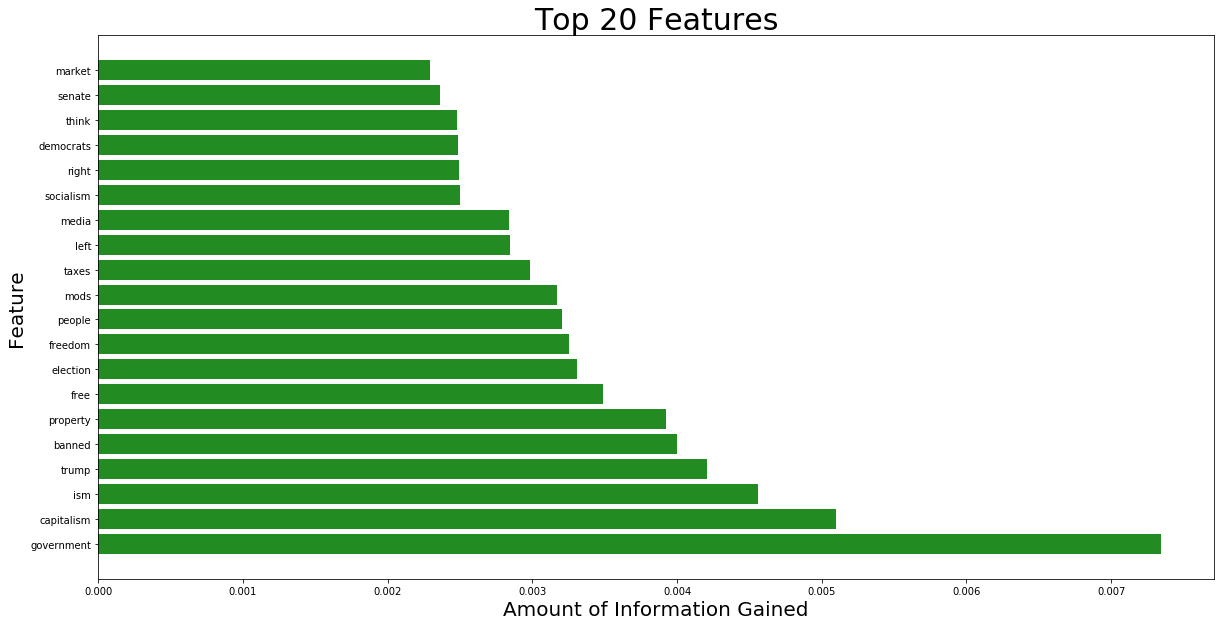

In [43]:
plt.figure(figsize=(20,10))
temp = feat_importance.sort_values('importance', ascending=False).head(20)
plt.barh(temp.index, temp['importance'], color='forestgreen')
plt.title('Top 20 Features', fontsize=30)
plt.xlabel('Amount of Information Gained', fontsize=20)
plt.ylabel('Feature', fontsize=20)

plt.savefig('../images/rf20info2.png', dpi=300)

The top 20 features are encouraging because they hold high relavence to our political subject matter without being unduly correlated with one group or the other. This indicates that the model is grasping on to features that are intuitive important to this classification problem. The only questionable word on the list is 'ism', which may be an artifact from lemmatization as a disembodied suffix. 

Listing out the min_samples_splits for plotting to understand if the gridsearch found a locally optimal value or a global optimum.

In [44]:
[param['min_samples_split'] for param in gs.cv_results_['params']]

[25]

In [45]:
gs.cv_results_['mean_test_score']

array([0.69675928])

Text(0.5, 1.0, 'Mean Test Score vs. Min Samples Split')

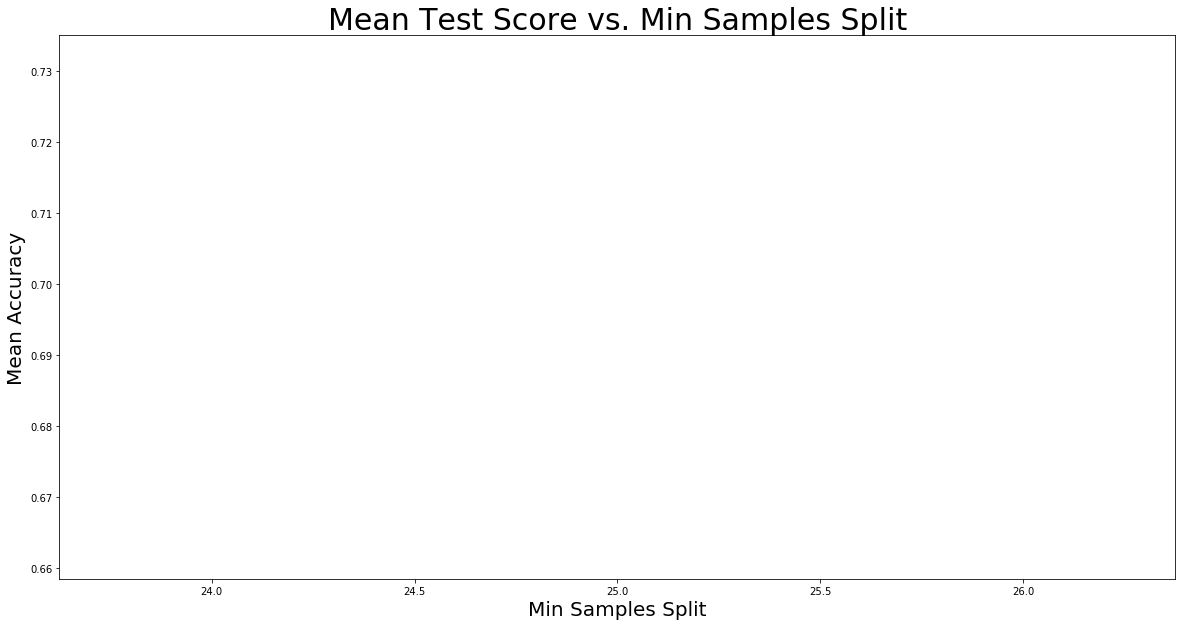

In [46]:
plt.figure(figsize=(20,10))
plt.plot([param['min_samples_split'] for param in gs.cv_results_['params']], gs.cv_results_['mean_test_score'])
plt.xlabel('Min Samples Split', fontsize=20)
plt.ylabel('Mean Accuracy', fontsize=20)
plt.title('Mean Test Score vs. Min Samples Split', fontsize=30)

We see a sharp inflection point at 25 and then a decrease to 50. There may well be values above 50 that provide a similar level of accuracy but going too large risks a shallow tree that leaves many samples incorrecly classified. At this stage it would be more informative to try optimizing n_estimators than the tree depth.